In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable

### Creating config object (argparse workaround)

In [2]:
class Config:
    pass

config = Config()
config.mnist_path = None
config.batch_size = 16
config.num_workers = 3
config.num_epochs = 10
config.noise_size = 50
config.print_freq = 100


### Create dataloder

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

0it [00:00, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion_mnist/FashionMNIST/raw


0it [00:00, ?it/s]

Extracting fashion_mnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion_mnist/FashionMNIST/raw
Processing...
Done!


/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
dataloader = DataLoader(train, batch_size=16, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
for image, cat in dataloader:
    break

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

In [8]:
28*28

784

### Create generator and discriminator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [10]:
generator = Generator()
discriminator = Discriminator()

### Create optimizers and loss

In [11]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

criterion = nn.BCELoss()

### Create necessary variables

In [12]:
input = Variable(torch.FloatTensor(config.batch_size, 28*28))
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size))
fixed_noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size).normal_(0, 1))
label = Variable(torch.FloatTensor(config.batch_size))
real_label = 1
fake_label = 0

### Задание

1) Посмотрите на реализацию GAN. Постройте интерполяцию между какими-нибудь двумя сгенерированными картинками. (Опционально)Добавьте свертки в генератор и дискриминатор, как в статье про DCGAN.

2) Поменяйте ее, чтобы получился LSGAN https://arxiv.org/pdf/1611.04076v2.pdf

3) Добавьте к обучению GAN условие на метку, продемонстрируйте условную генерацию. https://arxiv.org/pdf/1411.1784.pdf

4) Напишите отчет что попробовали, какие результаты получили, как вам кажется надо обучать GAN, чтобы добиться сходимости?

В каждом пункте постройте графики функций потерь.

### GAN

In [125]:
optim_G = optim.Adam(params=generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=discriminator.parameters(), lr=0.0001)

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

gan_losses = {'errD_x': [], 'errD_z': [], 'errG': []}

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        # b for real label and a for fake one
        # 1/2 * (D(x) - b ** 2) + 1/2 * (D(G(z)) - a ** 2)
        discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1) #16 28 28
        output = discriminator(input_data)
        errD_x = criterion(output, torch.unsqueeze(label, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = generator(noise)
        label.data.fill_(fake_label)
        output = discriminator(fake.detach())
        errD_z = criterion(output, torch.unsqueeze(label, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        # c for value that G wants to make D believe for fake data
        # 1 / 2 * (D(G(z)) - c ** 2)
        generator.zero_grad()
        label.data.fill_(real_label)
        output = discriminator(fake)
        errG = criterion(output, torch.unsqueeze(label, 1))
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
            gan_losses['errD_x'].append(errD_x.item())
            gan_losses['errD_z'].append(errD_z.item())
            gan_losses['errG'].append(errG.item())

Epoch:1 Iter: 100 errD_x: 0.00 errD_z: 0.00 errG: 11.58
Epoch:1 Iter: 200 errD_x: 0.00 errD_z: 0.00 errG: 13.57
Epoch:1 Iter: 300 errD_x: 0.00 errD_z: 0.00 errG: 14.65
Epoch:1 Iter: 400 errD_x: 0.00 errD_z: 0.00 errG: 16.32
Epoch:1 Iter: 500 errD_x: 0.00 errD_z: 0.00 errG: 17.48
Epoch:1 Iter: 600 errD_x: 0.00 errD_z: 0.00 errG: 17.11
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.00 errG: 13.53
Epoch:1 Iter: 800 errD_x: 0.00 errD_z: 0.00 errG: 18.17
Epoch:1 Iter: 900 errD_x: 0.00 errD_z: 0.00 errG: 14.22
Epoch:1 Iter: 1000 errD_x: 0.00 errD_z: 0.00 errG: 15.33
Epoch:1 Iter: 1100 errD_x: 0.00 errD_z: 0.00 errG: 11.21
Epoch:1 Iter: 1200 errD_x: 0.00 errD_z: 0.00 errG: 12.69
Epoch:1 Iter: 1300 errD_x: 0.00 errD_z: 0.00 errG: 13.39
Epoch:1 Iter: 1400 errD_x: 0.00 errD_z: 0.00 errG: 15.08
Epoch:1 Iter: 1500 errD_x: 0.00 errD_z: 0.00 errG: 15.36
Epoch:1 Iter: 1600 errD_x: 0.00 errD_z: 0.00 errG: 16.57
Epoch:1 Iter: 1700 errD_x: 0.00 errD_z: 0.00 errG: 18.12
Epoch:1 Iter: 1800 errD_x: 0.00 errD_z: 

Epoch:4 Iter: 3700 errD_x: 0.49 errD_z: 0.23 errG: 2.01
Epoch:5 Iter: 100 errD_x: 0.45 errD_z: 0.15 errG: 2.41
Epoch:5 Iter: 200 errD_x: 0.70 errD_z: 0.25 errG: 1.85
Epoch:5 Iter: 300 errD_x: 0.48 errD_z: 0.64 errG: 1.01
Epoch:5 Iter: 400 errD_x: 0.33 errD_z: 0.64 errG: 1.47
Epoch:5 Iter: 500 errD_x: 0.45 errD_z: 0.28 errG: 1.89
Epoch:5 Iter: 600 errD_x: 0.63 errD_z: 0.29 errG: 1.85
Epoch:5 Iter: 700 errD_x: 0.75 errD_z: 0.40 errG: 1.61
Epoch:5 Iter: 800 errD_x: 1.14 errD_z: 0.23 errG: 2.10
Epoch:5 Iter: 900 errD_x: 0.49 errD_z: 0.19 errG: 2.26
Epoch:5 Iter: 1000 errD_x: 0.54 errD_z: 0.24 errG: 2.05
Epoch:5 Iter: 1100 errD_x: 0.53 errD_z: 0.26 errG: 1.95
Epoch:5 Iter: 1200 errD_x: 0.31 errD_z: 0.57 errG: 1.17
Epoch:5 Iter: 1300 errD_x: 0.24 errD_z: 0.28 errG: 2.41
Epoch:5 Iter: 1400 errD_x: 0.48 errD_z: 0.26 errG: 2.00
Epoch:5 Iter: 1500 errD_x: 0.85 errD_z: 0.29 errG: 1.86
Epoch:5 Iter: 1600 errD_x: 0.53 errD_z: 0.52 errG: 1.50
Epoch:5 Iter: 1700 errD_x: 0.06 errD_z: 0.38 errG: 2.10
E

Epoch:8 Iter: 3600 errD_x: 0.35 errD_z: 0.18 errG: 2.36
Epoch:8 Iter: 3700 errD_x: 0.50 errD_z: 0.39 errG: 1.19
Epoch:9 Iter: 100 errD_x: 0.46 errD_z: 0.28 errG: 1.82
Epoch:9 Iter: 200 errD_x: 0.38 errD_z: 0.32 errG: 1.71
Epoch:9 Iter: 300 errD_x: 0.36 errD_z: 0.42 errG: 1.36
Epoch:9 Iter: 400 errD_x: 0.41 errD_z: 0.41 errG: 1.27
Epoch:9 Iter: 500 errD_x: 0.65 errD_z: 0.28 errG: 1.46
Epoch:9 Iter: 600 errD_x: 0.40 errD_z: 0.33 errG: 2.20
Epoch:9 Iter: 700 errD_x: 0.43 errD_z: 0.41 errG: 1.43
Epoch:9 Iter: 800 errD_x: 0.77 errD_z: 0.28 errG: 1.60
Epoch:9 Iter: 900 errD_x: 0.86 errD_z: 0.39 errG: 1.26
Epoch:9 Iter: 1000 errD_x: 0.67 errD_z: 0.26 errG: 1.57
Epoch:9 Iter: 1100 errD_x: 0.34 errD_z: 0.46 errG: 1.27
Epoch:9 Iter: 1200 errD_x: 0.53 errD_z: 0.18 errG: 2.05
Epoch:9 Iter: 1300 errD_x: 0.19 errD_z: 0.38 errG: 1.65
Epoch:9 Iter: 1400 errD_x: 0.27 errD_z: 0.36 errG: 1.50
Epoch:9 Iter: 1500 errD_x: 0.48 errD_z: 0.52 errG: 1.20
Epoch:9 Iter: 1600 errD_x: 0.83 errD_z: 0.32 errG: 1.36
E

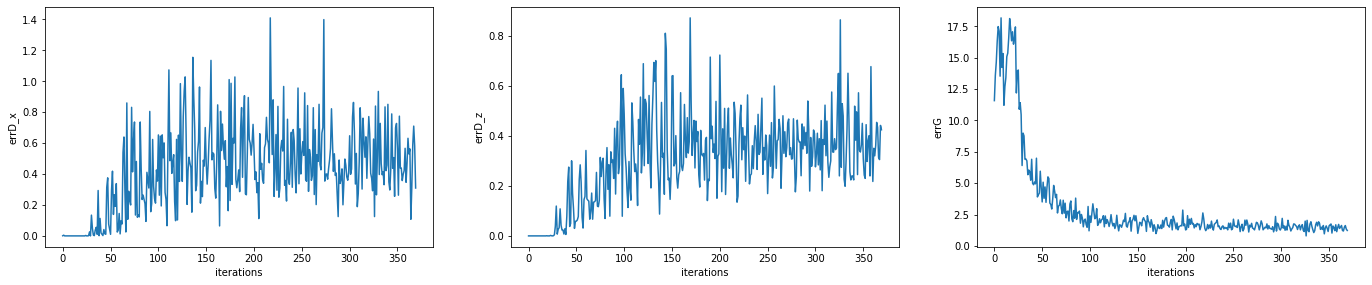

In [126]:
plt.figure(figsize=(32, 15))
for i, key in enumerate(gan_losses):
    plt.subplot(3, 4, i + 1)
    plt.plot(gan_losses[key])
    plt.xlabel('iterations')
    plt.ylabel(key)

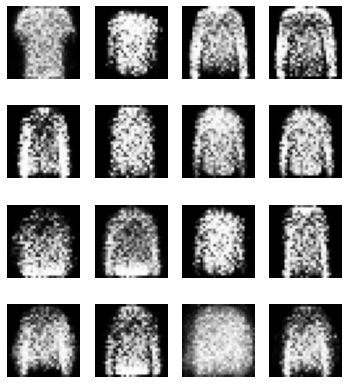

In [20]:
noise.data.normal_(0, 1)
fake = generator(noise)

plt.figure(figsize=(6, 7))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(fake[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [81]:
def interpolate(z0, z1, frames_num):
    middles = []
    for i in range(frames_num):
        alpha = i / frames_num
        z = (1 - alpha) * z0 + alpha * z1
        middles.append(generator(z.data.normal_(0, 1)))
    return middles

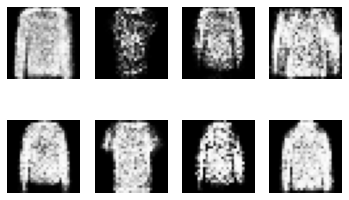

In [87]:
z0 = noise.data.normal_(0, 1)[0]
z1 = noise.data.normal_(0, 1)[1]
gan_middles = [generator(z0)] + interpolate(z0, z1, 6) + [generator(z1)]

plt.figure(figsize=(6, 8))
for i in range(8):
    plt.subplot(4, 4, i + 1)
    plt.imshow(gan_middles[i].detach().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.axis('off')

In [114]:
lsgan_generator = Generator()
lsgan_discriminator = Discriminator()

optim_G = optim.Adam(params=lsgan_generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=lsgan_discriminator.parameters(), lr=0.0001)

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)
loss = torch.nn.MSELoss(reduce='mean')

losses = {'errD_x': [], 'errD_z': [], 'errG': []}

def LSGANcrit(output, label):
    return 1 / 2 * loss(output, label)


for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        ####### 
        # Discriminator stage: maximize log(D(x)) + log(1 - D(G(z))) 
        #######
        # b for real label and a for fake one
        # 1/2 * (D(x) - b) ** 2 + 1/2 * (D(G(z)) - a) ** 2
        lsgan_discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        output = lsgan_discriminator(input_data)
        errD_x = LSGANcrit(output, torch.unsqueeze(label, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = lsgan_generator(noise)
        label.data.fill_(fake_label)
        output = lsgan_discriminator(fake.detach())
        errD_z = LSGANcrit(output, torch.unsqueeze(label, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        ####### 
        # Generator stage: maximize log(D(G(x))
        #######
        # c for value that G wants to make D believe for fake data
        # 1 / 2 * (D(G(z)) - c) ** 2
        lsgan_generator.zero_grad()
        label.data.fill_(real_label)
        output = lsgan_discriminator(fake)
        errG = LSGANcrit(output, torch.unsqueeze(label, 1))
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1, iteration+1, 
                                                                    errD_x.item(), errD_z.item(), errG.item()))
            losses['errD_x'].append(errD_x.item())
            losses['errD_z'].append(errD_z.item())
            losses['errG'].append(errG.item())

Epoch:1 Iter: 100 errD_x: 0.02 errD_z: 0.01 errG: 0.37
Epoch:1 Iter: 200 errD_x: 0.04 errD_z: 0.01 errG: 0.40
Epoch:1 Iter: 300 errD_x: 0.04 errD_z: 0.01 errG: 0.40
Epoch:1 Iter: 400 errD_x: 0.02 errD_z: 0.01 errG: 0.38
Epoch:1 Iter: 500 errD_x: 0.03 errD_z: 0.01 errG: 0.38
Epoch:1 Iter: 600 errD_x: 0.01 errD_z: 0.01 errG: 0.39
Epoch:1 Iter: 700 errD_x: 0.00 errD_z: 0.02 errG: 0.37
Epoch:1 Iter: 800 errD_x: 0.05 errD_z: 0.01 errG: 0.38
Epoch:1 Iter: 900 errD_x: 0.03 errD_z: 0.01 errG: 0.38
Epoch:1 Iter: 1000 errD_x: 0.01 errD_z: 0.06 errG: 0.29
Epoch:1 Iter: 1100 errD_x: 0.03 errD_z: 0.02 errG: 0.35
Epoch:1 Iter: 1200 errD_x: 0.01 errD_z: 0.03 errG: 0.35
Epoch:1 Iter: 1300 errD_x: 0.04 errD_z: 0.06 errG: 0.25
Epoch:1 Iter: 1400 errD_x: 0.02 errD_z: 0.01 errG: 0.39
Epoch:1 Iter: 1500 errD_x: 0.02 errD_z: 0.01 errG: 0.42
Epoch:1 Iter: 1600 errD_x: 0.05 errD_z: 0.02 errG: 0.38
Epoch:1 Iter: 1700 errD_x: 0.01 errD_z: 0.03 errG: 0.39
Epoch:1 Iter: 1800 errD_x: 0.02 errD_z: 0.01 errG: 0.43
E

Epoch:4 Iter: 3700 errD_x: 0.02 errD_z: 0.05 errG: 0.40
Epoch:5 Iter: 100 errD_x: 0.04 errD_z: 0.02 errG: 0.38
Epoch:5 Iter: 200 errD_x: 0.06 errD_z: 0.01 errG: 0.39
Epoch:5 Iter: 300 errD_x: 0.04 errD_z: 0.02 errG: 0.40
Epoch:5 Iter: 400 errD_x: 0.01 errD_z: 0.03 errG: 0.32
Epoch:5 Iter: 500 errD_x: 0.05 errD_z: 0.02 errG: 0.35
Epoch:5 Iter: 600 errD_x: 0.09 errD_z: 0.04 errG: 0.33
Epoch:5 Iter: 700 errD_x: 0.16 errD_z: 0.00 errG: 0.43
Epoch:5 Iter: 800 errD_x: 0.02 errD_z: 0.04 errG: 0.34
Epoch:5 Iter: 900 errD_x: 0.05 errD_z: 0.01 errG: 0.40
Epoch:5 Iter: 1000 errD_x: 0.06 errD_z: 0.01 errG: 0.42
Epoch:5 Iter: 1100 errD_x: 0.07 errD_z: 0.04 errG: 0.33
Epoch:5 Iter: 1200 errD_x: 0.05 errD_z: 0.12 errG: 0.24
Epoch:5 Iter: 1300 errD_x: 0.00 errD_z: 0.09 errG: 0.31
Epoch:5 Iter: 1400 errD_x: 0.05 errD_z: 0.02 errG: 0.38
Epoch:5 Iter: 1500 errD_x: 0.08 errD_z: 0.01 errG: 0.40
Epoch:5 Iter: 1600 errD_x: 0.01 errD_z: 0.02 errG: 0.42
Epoch:5 Iter: 1700 errD_x: 0.09 errD_z: 0.02 errG: 0.36
E

Epoch:8 Iter: 3600 errD_x: 0.12 errD_z: 0.08 errG: 0.31
Epoch:8 Iter: 3700 errD_x: 0.11 errD_z: 0.06 errG: 0.26
Epoch:9 Iter: 100 errD_x: 0.02 errD_z: 0.06 errG: 0.33
Epoch:9 Iter: 200 errD_x: 0.09 errD_z: 0.08 errG: 0.29
Epoch:9 Iter: 300 errD_x: 0.10 errD_z: 0.05 errG: 0.36
Epoch:9 Iter: 400 errD_x: 0.01 errD_z: 0.07 errG: 0.33
Epoch:9 Iter: 500 errD_x: 0.09 errD_z: 0.02 errG: 0.40
Epoch:9 Iter: 600 errD_x: 0.12 errD_z: 0.04 errG: 0.30
Epoch:9 Iter: 700 errD_x: 0.08 errD_z: 0.05 errG: 0.30
Epoch:9 Iter: 800 errD_x: 0.08 errD_z: 0.03 errG: 0.38
Epoch:9 Iter: 900 errD_x: 0.04 errD_z: 0.03 errG: 0.31
Epoch:9 Iter: 1000 errD_x: 0.07 errD_z: 0.02 errG: 0.39
Epoch:9 Iter: 1100 errD_x: 0.09 errD_z: 0.05 errG: 0.34
Epoch:9 Iter: 1200 errD_x: 0.02 errD_z: 0.02 errG: 0.39
Epoch:9 Iter: 1300 errD_x: 0.09 errD_z: 0.06 errG: 0.31
Epoch:9 Iter: 1400 errD_x: 0.04 errD_z: 0.06 errG: 0.33
Epoch:9 Iter: 1500 errD_x: 0.08 errD_z: 0.03 errG: 0.35
Epoch:9 Iter: 1600 errD_x: 0.02 errD_z: 0.08 errG: 0.31
E

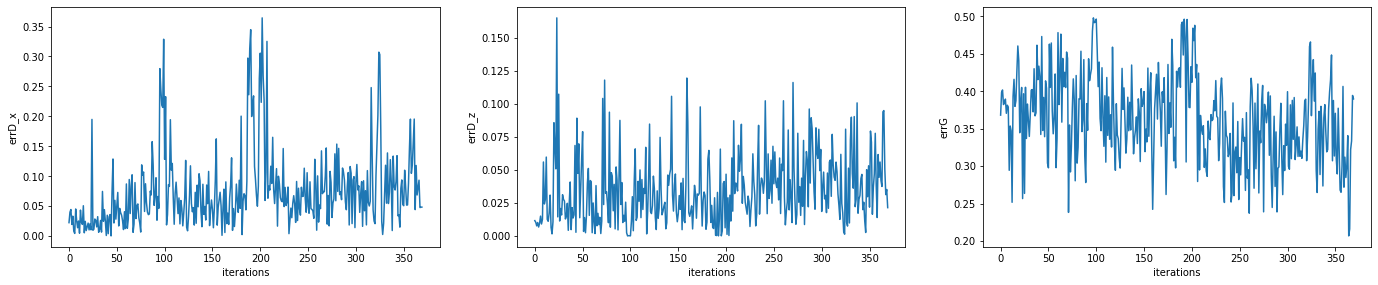

In [121]:
plt.figure(figsize=(32, 15))
for i, key in enumerate(losses):
    plt.subplot(3, 4, i + 1)
    plt.plot(losses[key])
    plt.xlabel('iterations')
    plt.ylabel(key)

In [94]:
def onehot(classes, class_num=10):
    encoding = Variable(torch.zeros(config.batch_size, class_num))
    for i in range(config.batch_size):
        encoding[i][classes[i] - 1] = 1
    return encoding

In [103]:
class CGenerator(nn.Module):
    def __init__(self):
        super(CGenerator, self).__init__()
        self.model = nn.Sequential( 
            nn.Linear(config.noise_size + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 28*28),
            nn.Sigmoid())
        
    def forward(self, x):
        return self.model(x)
    
class CDiscriminator(nn.Module):
    def __init__(self):
        super(CDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28 + 10, 200),
            nn.ReLU(inplace=True),
            nn.Linear(200, 50),
            nn.ReLU(inplace=True),
            nn.Linear(50, 1), 
            nn.Sigmoid())
    def forward(self, x):
        return self.model(x)

In [122]:
cgan_generator = CGenerator()
cgan_discriminator = CDiscriminator()

optim_G = optim.Adam(params=cgan_generator.parameters(), lr=0.0001)
optim_D = optim.Adam(params=cgan_discriminator.parameters(), lr=0.0001)

ERRD_x = np.zeros(config.num_epochs)
ERRD_z = np.zeros(config.num_epochs)
ERRG = np.zeros(config.num_epochs)
N = len(dataloader)

cgan_losses = {'errD_x': [], 'errD_z': [], 'errG': []}

for epoch in range(config.num_epochs):
    for iteration, (images, cat) in enumerate(dataloader):
        cgan_discriminator.zero_grad()
        
        # real
        label.data.fill_(real_label)
        input_data = images.view(images.shape[0], -1)
        y = onehot(cat)
        output = cgan_discriminator(torch.cat([input_data, y], dim=1))
        errD_x = criterion(output, torch.unsqueeze(label, 1))
        ERRD_x[epoch] += errD_x.item()
        errD_x.backward()
        
        # fake 
        noise.data.normal_(0, 1)
        fake = cgan_generator(torch.cat([noise, y], dim=1))
        label.data.fill_(fake_label)
        output = cgan_discriminator(torch.cat([fake.detach(), y], dim=1))
        errD_z = criterion(output, torch.unsqueeze(label, 1))
        ERRD_z[epoch] += errD_z.item()
        errD_z.backward()
        
        optim_D.step()
        
        cgan_generator.zero_grad()
        label.data.fill_(real_label)
        output = cgan_discriminator(torch.cat([fake, y], dim=1))
        errG = criterion(output, torch.unsqueeze(label, 1))
        ERRG[epoch] += errG.item()
        errG.backward()
        
        optim_G.step()
        
        if (iteration+1) % config.print_freq == 0:
            print('Epoch:{} Iter: {} errD_x: {:.2f} errD_z: {:.2f} errG: {:.2f}'.format(epoch+1,
                                                                                            iteration+1, 
                                                                                            errD_x.item(),
                                                                                            errD_z.item(), 
                                                                                            errG.item()))
            cgan_losses['errD_x'].append(errD_x.item())
            cgan_losses['errD_z'].append(errD_z.item())
            cgan_losses['errG'].append(errG.item())

Epoch:1 Iter: 100 errD_x: 0.17 errD_z: 0.09 errG: 2.55
Epoch:1 Iter: 200 errD_x: 0.21 errD_z: 0.12 errG: 2.50
Epoch:1 Iter: 300 errD_x: 0.18 errD_z: 0.12 errG: 2.33
Epoch:1 Iter: 400 errD_x: 0.21 errD_z: 0.05 errG: 3.16
Epoch:1 Iter: 500 errD_x: 0.18 errD_z: 0.07 errG: 2.88
Epoch:1 Iter: 600 errD_x: 0.40 errD_z: 0.05 errG: 3.20
Epoch:1 Iter: 700 errD_x: 0.23 errD_z: 0.08 errG: 2.73
Epoch:1 Iter: 800 errD_x: 0.13 errD_z: 0.05 errG: 3.34
Epoch:1 Iter: 900 errD_x: 0.07 errD_z: 0.08 errG: 2.91
Epoch:1 Iter: 1000 errD_x: 0.09 errD_z: 0.08 errG: 3.09
Epoch:1 Iter: 1100 errD_x: 0.29 errD_z: 0.10 errG: 3.02
Epoch:1 Iter: 1200 errD_x: 0.17 errD_z: 0.07 errG: 3.08
Epoch:1 Iter: 1300 errD_x: 0.06 errD_z: 0.17 errG: 2.57
Epoch:1 Iter: 1400 errD_x: 0.25 errD_z: 0.12 errG: 2.61
Epoch:1 Iter: 1500 errD_x: 0.37 errD_z: 0.17 errG: 2.50
Epoch:1 Iter: 1600 errD_x: 0.03 errD_z: 0.19 errG: 2.96
Epoch:1 Iter: 1700 errD_x: 0.17 errD_z: 0.11 errG: 3.20
Epoch:1 Iter: 1800 errD_x: 0.13 errD_z: 0.10 errG: 3.20
E

Epoch:4 Iter: 3700 errD_x: 0.14 errD_z: 0.09 errG: 4.09
Epoch:5 Iter: 100 errD_x: 0.12 errD_z: 0.14 errG: 3.77
Epoch:5 Iter: 200 errD_x: 0.43 errD_z: 0.21 errG: 3.27
Epoch:5 Iter: 300 errD_x: 0.70 errD_z: 0.15 errG: 3.88
Epoch:5 Iter: 400 errD_x: 0.21 errD_z: 0.16 errG: 3.49
Epoch:5 Iter: 500 errD_x: 0.16 errD_z: 0.12 errG: 2.96
Epoch:5 Iter: 600 errD_x: 0.02 errD_z: 0.52 errG: 3.06
Epoch:5 Iter: 700 errD_x: 0.43 errD_z: 0.24 errG: 2.63
Epoch:5 Iter: 800 errD_x: 0.67 errD_z: 0.31 errG: 3.63
Epoch:5 Iter: 900 errD_x: 0.11 errD_z: 0.20 errG: 4.74
Epoch:5 Iter: 1000 errD_x: 0.35 errD_z: 0.12 errG: 4.06
Epoch:5 Iter: 1100 errD_x: 0.23 errD_z: 0.12 errG: 5.41
Epoch:5 Iter: 1200 errD_x: 0.45 errD_z: 0.08 errG: 4.09
Epoch:5 Iter: 1300 errD_x: 0.03 errD_z: 0.06 errG: 4.35
Epoch:5 Iter: 1400 errD_x: 0.34 errD_z: 0.07 errG: 5.29
Epoch:5 Iter: 1500 errD_x: 0.23 errD_z: 0.07 errG: 4.93
Epoch:5 Iter: 1600 errD_x: 0.15 errD_z: 0.18 errG: 4.44
Epoch:5 Iter: 1700 errD_x: 1.11 errD_z: 0.14 errG: 3.88
E

Epoch:8 Iter: 3600 errD_x: 0.44 errD_z: 0.12 errG: 3.07
Epoch:8 Iter: 3700 errD_x: 0.61 errD_z: 0.15 errG: 3.18
Epoch:9 Iter: 100 errD_x: 0.62 errD_z: 0.24 errG: 3.24
Epoch:9 Iter: 200 errD_x: 0.60 errD_z: 0.30 errG: 3.91
Epoch:9 Iter: 300 errD_x: 0.28 errD_z: 0.32 errG: 2.57
Epoch:9 Iter: 400 errD_x: 0.36 errD_z: 0.33 errG: 2.89
Epoch:9 Iter: 500 errD_x: 0.37 errD_z: 0.20 errG: 2.78
Epoch:9 Iter: 600 errD_x: 0.17 errD_z: 0.10 errG: 3.97
Epoch:9 Iter: 700 errD_x: 0.09 errD_z: 0.15 errG: 3.22
Epoch:9 Iter: 800 errD_x: 0.04 errD_z: 0.14 errG: 3.25
Epoch:9 Iter: 900 errD_x: 0.03 errD_z: 0.26 errG: 3.10
Epoch:9 Iter: 1000 errD_x: 0.43 errD_z: 0.15 errG: 3.17
Epoch:9 Iter: 1100 errD_x: 0.24 errD_z: 0.31 errG: 3.67
Epoch:9 Iter: 1200 errD_x: 0.72 errD_z: 0.40 errG: 3.67
Epoch:9 Iter: 1300 errD_x: 0.24 errD_z: 0.12 errG: 3.12
Epoch:9 Iter: 1400 errD_x: 0.24 errD_z: 0.38 errG: 2.92
Epoch:9 Iter: 1500 errD_x: 0.48 errD_z: 0.24 errG: 2.70
Epoch:9 Iter: 1600 errD_x: 0.02 errD_z: 0.17 errG: 3.39
E

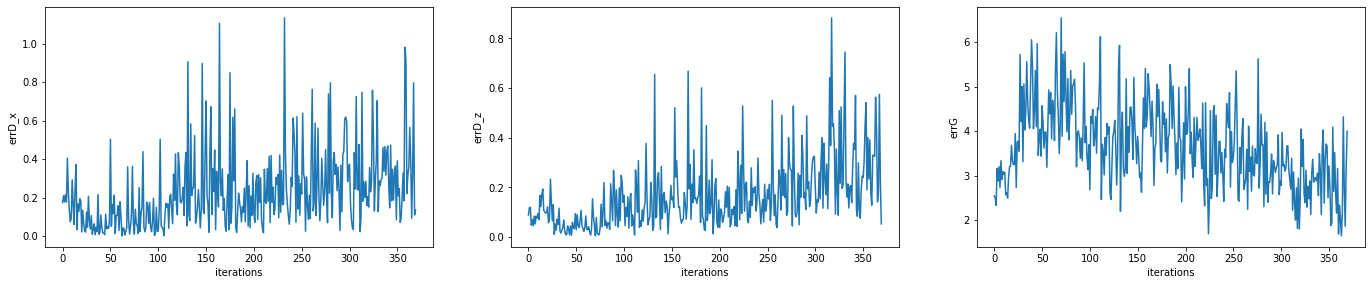

In [124]:
plt.figure(figsize=(32, 15))
for i, key in enumerate(cgan_losses):
    plt.subplot(3, 4, i + 1)
    plt.plot(cgan_losses[key])
    plt.xlabel('iterations')
    plt.ylabel(key)

Были опробованы три модели: GAN, LSGAN и GAN с условием на метку.
GAN очень хорошо смог обучить генератор: его лосс стремительно падал, а лоссы дискриминатора в среднем выросли.
LSGAN с самого начала показал результаты лучше, чем обычный GAN: его лосс были изначально меньше. Видно, что лосс генератора имеет четкую тенденцию на уменьшение.
GAN с условием на метку: лосс для генератора падает, а дискриминатору становилось сложнее отличать ненастоящие объекты от настоящих и наоборот.